In [35]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

import consts as CONSTS
import utils as UTILS
import hydronet as NET
import datamanager as DataManager

In [36]:
mse_loss = NET.MixMSELoss()
mae_acc = NET.L1Accuracy()

BATCH_SIZE = 4
LR = 0.001
EPOCHS = 50
SCHEDULER_MILESTONES = [25, 50]

device = 'cpu'
if torch.cuda.is_available():
    device = torch.device('cuda')

In [37]:
def test(net: nn.Module, test_loader: DataLoader, loss_module: nn.Module, acc_module: nn.Module):
    loss_sum = 0
    acc_sum = 0
    net.eval()

    for _, train_batch in enumerate(test_loader):

        input, target = train_batch
        input = input.to(device)
        target = target.to(device)
        with torch.no_grad():
            predict = net(input)

        loss = loss_module(predict, target)
        acc = acc_module(predict, target)

        loss_sum += loss.item()
        acc_sum += acc.item()

    net.train()

    return loss_sum/len(test_loader), acc_sum/len(test_loader)

In [38]:
def train(net: nn.Module, train_loader: DataLoader, test_loader: DataLoader):

    record = []
    optimizer = torch.optim.Adam(net.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=SCHEDULER_MILESTONES, gamma=0.5)

    for epoch in range(1, EPOCHS+1):

        train_loss = 0
        train_acc = 0

        # mse_loss.logarithmic_ratio = (EPOCHS - epoch * 0.5) / EPOCHS
        mse_loss.logarithmic_ratio = 0.9
        
        for _, train_batch in enumerate(train_loader):

            input, target = train_batch
            input = input.to(device)
            target = target.to(device)

            predict = net(input)

            mseloss = mse_loss(predict, target)
            accuracy = mae_acc(predict, target)

            optimizer.zero_grad()
            mseloss.backward()
            optimizer.step()

            train_loss += mseloss.item()
            train_acc += accuracy.item()

        train_loss = train_loss/len(train_loader)
        train_acc = train_acc/len(train_loader)
        test_loss, test_acc = test(hn, test_loader, mse_loss, mae_acc)
        print('epoch count: ', epoch, 'train loss: ', train_loss, 'train acc: ', train_acc, 'test loss: ', test_loss, 'test acc: ', test_acc)
        record.append([train_loss, train_acc, test_loss, test_acc])

        scheduler.step()

    return record

In [39]:
# load data
train_test_ratio = 0.8
train_set = DataManager.HydroDataset('norm_data.npy', is_training=True, train_test_ratio=train_test_ratio)
test_set = DataManager.HydroDataset('norm_data.npy', is_training=False, train_test_ratio=train_test_ratio)

train_loader = DataLoader(train_set, BATCH_SIZE, True)
test_loader = DataLoader(test_set, BATCH_SIZE, False)

In [6]:
hn = NET.HydroNet(input_channel=13, conv_channel=16, lstm_hidden_channel=32, lstm_layers=2, bidirectional=True)
hn = hn.to(device)

In [7]:
rec = train(hn, train_loader, test_loader)

epoch count:  1 train loss:  0.02768112147570632 train acc:  0.8648781634512401 test loss:  0.018089391669491306 test acc:  0.9245562826593717
epoch count:  2 train loss:  0.012879847005907712 train acc:  0.9274572667621431 test loss:  0.014408804767299443 test acc:  0.9368526265025139
epoch count:  3 train loss:  0.010816755843171407 train acc:  0.9340063702492487 test loss:  0.013629180287049772 test acc:  0.9401195794343948
epoch count:  4 train loss:  0.008776429341690215 train acc:  0.9397552995454698 test loss:  0.011744932742052091 test acc:  0.9459004277984301
epoch count:  5 train loss:  0.007677734445314855 train acc:  0.9441681475866408 test loss:  0.01224522107077064 test acc:  0.9428511733810107
epoch count:  6 train loss:  0.0073326444630289365 train acc:  0.9447872076715742 test loss:  0.008507807287363297 test acc:  0.9565576513608297
epoch count:  7 train loss:  0.0070209223738250635 train acc:  0.9456909855206808 test loss:  0.009209194281235492 test acc:  0.952682872

In [8]:
input, _ = test_set[0]

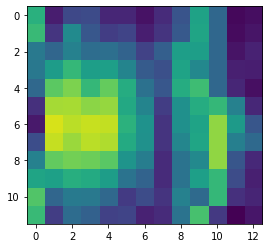

In [9]:
plt.imshow(input.cpu().detach(), vmin=0, vmax=1)

In [10]:
out = hn.conv1(input.unsqueeze(0).permute(0,2,1).unsqueeze(2).to(device))

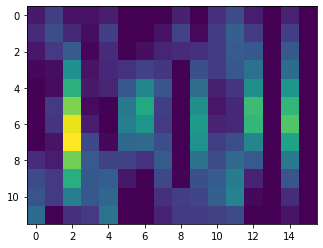

In [11]:
plt.imshow(out[0,:,0].cpu().detach().permute(1,0))

In [12]:
rec = np.array(rec)

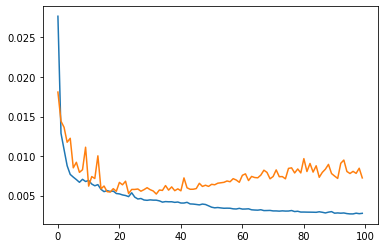

In [13]:
plt.plot(rec[:,0])
plt.plot(rec[:,2])

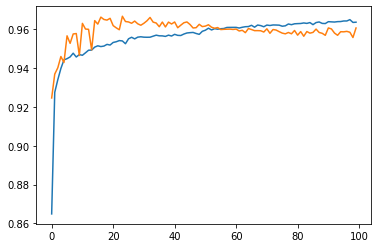

In [14]:
plt.plot(rec[:,1])
plt.plot(rec[:,3])

In [35]:
for _, test_batch in enumerate(test_loader):
    input, target = test_batch
    input = input.to(device)
    target = target.to(device)
    with torch.no_grad():
        predict = hn(input)
        

In [39]:
def denormalize_output(output):
    '''
    de-logarithmic
    '''
    max_bound, min_bound = CONSTS.BOUNDARIES[-1]
    output = output * (max_bound - min_bound) + min_bound
    return output

In [41]:
print(predict, denormalize_output(predict))
print(target, denormalize_output(target))

tensor([0.0902, 0.0727, 0.0490, 0.0171], device='cuda:0') tensor([18.0353, 14.5352,  9.8072,  3.4242], device='cuda:0')
tensor([0.0855, 0.0725, 0.0665, 0.0220], device='cuda:0') tensor([17.1000, 14.5000, 13.3000,  4.4000], device='cuda:0')


In [45]:
def plot_train():
    targets = []
    predicts = []
    for _, train_batch in enumerate(train_loader):
        input, target = train_batch
        input = input.to(device)
        target = target.to(device)
        with torch.no_grad():
            predict = hn(input)
        targets.extend(denormalize_output(target).cpu().detach().tolist())
        predicts.extend(denormalize_output(predict).cpu().detach().tolist())
    fig, axs = plt.subplots(1,1, figsize=(28, 5))
    axs.plot(targets, label='target')
    axs.plot(predicts, label='predict')
    plt.legend()

In [46]:
def plot_test():
    targets = []
    predicts = []
    for _, train_batch in enumerate(test_loader):
        input, target = train_batch
        input = input.to(device)
        target = target.to(device)
        with torch.no_grad():
            predict = hn(input)
        targets.extend(denormalize_output(target).cpu().detach().tolist())
        predicts.extend(denormalize_output(predict).cpu().detach().tolist())
    fig, axs = plt.subplots(1,1, figsize=(28, 5))
    axs.plot(targets, label='target')
    axs.plot(predicts, label='predict')
    plt.legend()

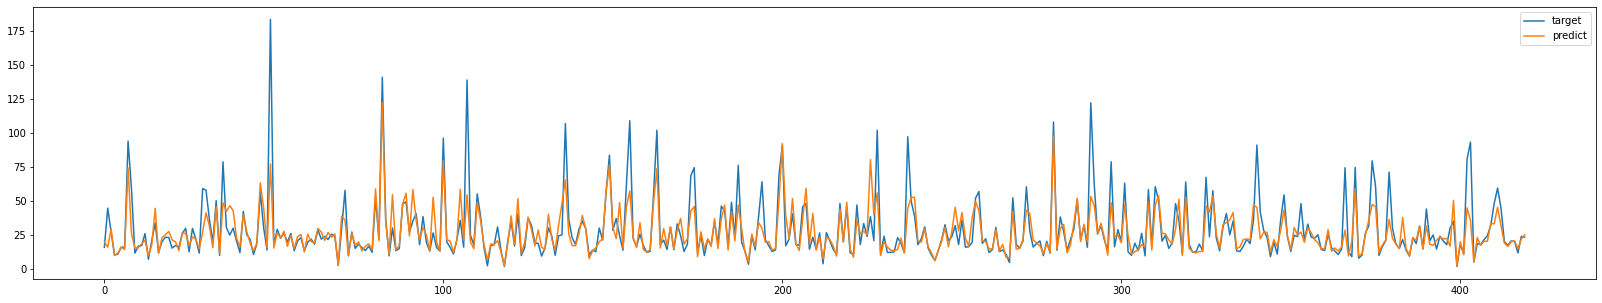

In [47]:
plot_train()
plt.show()

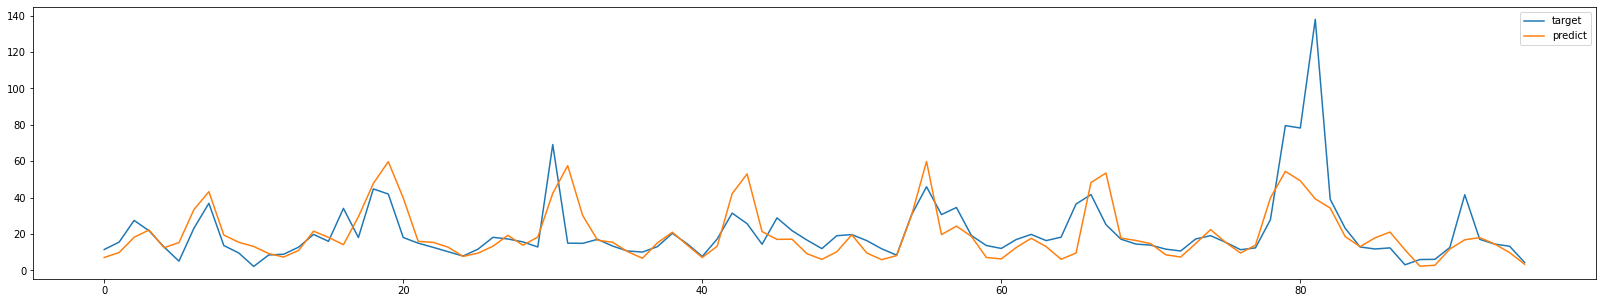

In [48]:
plot_test()

In [58]:
out_dev = out.cpu()

In [61]:
aa = out_dev[0,:,0].detach().permute(1,0)

In [62]:
aa.shape, out_dev.shape

(torch.Size([12, 16]), torch.Size([1, 16, 1, 12]))

In [65]:
nm = nn.BatchNorm2d(16)

normout = nm(out_dev)

In [66]:
bb = normout[0,:,0].detach().permute(1,0)

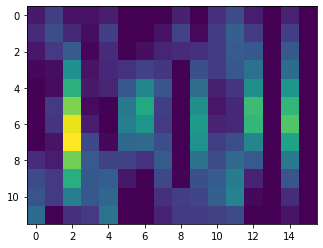

In [67]:
plt.imshow(aa)

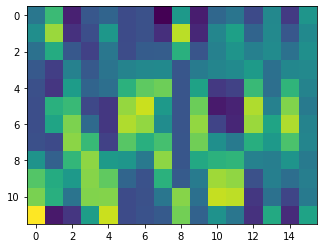

In [68]:
plt.imshow(bb)

In [30]:
a = torch.load('performance/conv_channel.pth')

In [31]:
a

[[16, 0.9870165228843689, 0.9632243886590004],
 [32, 0.9936292370160421, 0.963365395863851],
 [64, 0.9950935182117281, 0.9630094071229299],
 [128, 0.9962224148568652, 0.9649445538719496],
 [256, 0.9969903633708046, 0.9648135180274645]]

In [32]:
labels = []
train_accs = []
test_accs = []
for i in a:
    label, train_acc, test_acc = i
    labels.append(label)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

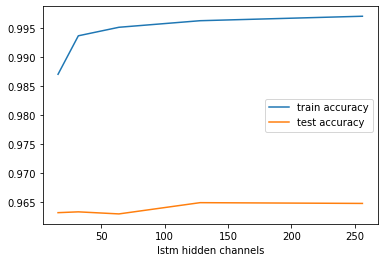

In [33]:
plt.xlabel('lstm hidden channels')
plt.plot(labels, train_accs, label='train accuracy')
plt.plot(labels, test_accs, label='test accuracy')
plt.legend()

In [93]:
rec = torch.load('performance/rec_cl_log90.pth')

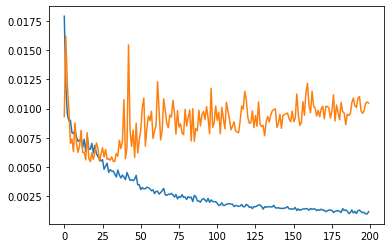

In [94]:
plt.plot(rec[:,0])
plt.plot(rec[:,2])

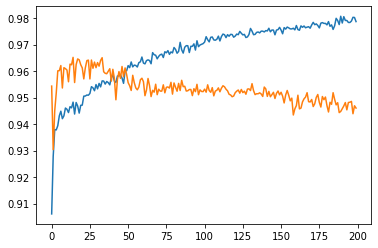

In [95]:
plt.plot(rec[:,1])
plt.plot(rec[:,3])

In [56]:
def load_model(dict_path):
    net = NET.HydroNetCNNLSTM(input_channel=13, conv_channel=32, lstm_hidden_channel=64, lstm_layers=2, bidirectional=True)
    net.load_state_dict(
        torch.load(dict_path, map_location=torch.device('cpu'))
    )
    return net

In [57]:
model_dict_path = 'net_dict/net_dict.pth'
net = load_model(model_dict_path)

AttributeError: module 'hydronet' has no attribute 'HydroNetCNNLSTM'

In [70]:
import math
import random

In [73]:
channels = 13
seq_len = 12

phase = random.random() * math.pi * 2

In [87]:
hor = torch.arange(0, seq_len) * math.pi * 2 / seq_len
ver = torch.arange(0, channels) * math.pi * 2 / channels

hor = hor[:,None]
ver = ver[None,:]
hor = hor.expand(seq_len, channels)
ver = ver.expand(seq_len, channels)

res = torch.sin(hor + ver + phase)

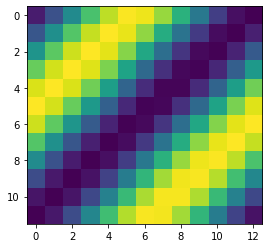

In [88]:
plt.imshow(res)

In [91]:
math.sin(phase)

-0.8465650057250395

In [92]:
res.min()

tensor(-1.0000)

In [96]:
a = torch.tensor([[2,3],[4,5]])
b = torch.tensor([[2,4],[4,1]])

torch.bmm(a,b)

RuntimeError: Expected 3-dimensional tensor, but got 2-dimensional tensor for argument #1 'batch1' (while checking arguments for bmm)